# [Advent of Code 2019](https://adventofcode.com/2019)
I'm going to have a go at the Advent of Code puzzles using a Jupyter notebook.

![50 stars](50-stars.png)

## Notes and Thoughts
This proved to be another wonderful collection of puzzles. This year, a good proportion of the puzzles were based on implementing an "Intcode" computer, capable of running programs written in a fully featured machine language. As December went on I had to extend the syntax of this langauge a few times, and also to run programs interactively and concurrently, and to implement program forking. Going back to basics is always fun and instructive.

As usual, the part one and part two format provided some surprises. I'd say there were not so many cases where part two was a simple tweak and re-run of part one: more often part two took the day's problem to another level.

So, thanks once again to [Eric Wastl](http://was.tl), and to get started, let's import some standard modules.

In [1]:
import cmath
import collections as cs
import dataclasses
import functools
import itertools as its
import math
import numbers
import operator as ops
import random
import re
import statistics
import string
import time
import typing
from pprint import pprint

Set up non-standard modules.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import graphviz as gv

Now, some standard functions.

In [3]:
def day(day):
    'Load the input for `day`'
    return open(f'input/{day}').read()

flatten = its.chain.from_iterable
cat = ''.join
ncat = '\n'.join
first = ops.itemgetter(0)
second = ops.itemgetter(1)

def ilen(xs):
    'Return the length of an iterable'
    return sum(1 for _ in iter(xs))

def cmp(a, b):
    'Return -1, 0, 1 if `a` is greater, equal or less than `b` respectively'
    return (a > b) - (a < b)

def last(xs):
    'Return the last element of an iterable sequence'
    return cs.deque(iter(xs), maxlen=1)[0]

def ints(s):
    'Return a tuple of integer tokens in `s`'
    return tuple(int(x) for x in re.findall(r'[-+]?\d+', s))

def array(data):
    'Convert the data into a tuple of int-tuples'
    return tuple(ints(line) for line in data.splitlines())

def swap(xs, i, j):
    'Swap items in a sequence.'
    xs[i], xs[j] = xs[j], xs[i]

def nth(xs, n):
    'Return the nth element of a sequence.'
    return next(its.islice(xs, n, None))

def take(xs, n=None):
    '''Return (up to) first `n` items of a sequence
    or the whole sequence if `n` is `None`
    '''
    return list(its.islice(xs, n))

def overlapping(xs, n):
    '''Generate overlapping n-tuples from `xs`

    overlapping('ABCDEFG', 3) --> ABC BCD CDE DEF EFG
    '''
    if isinstance(xs, cs.abc.Sequence):
        yield from (xs[i:i+n] for i in range(len(xs) + 1 - n))
    else:
        result = cs.deque(maxlen=n)
        for x in xs:
            result.append(x)
            if len(result) == n:
                yield tuple(result)
                
def pairwise(iterable):
    's -> (s0,s1), (s1,s2), (s2, s3), ...'
    return overlapping(iterable, 2)

def powerset(xs):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(xs)
    return flatten(its.combinations(s, r) for r in range(len(s)+1))

def repeated(xs):
    'Generated the repeated items in `xs`'
    seen = set()
    for x in xs:
        if x in seen:
            yield x
        seen.add(x)

def unfold(f, x):
    'Generate the sequence x, f(x), f(f(x)), ...'
    while True:
        yield x
        x = f(x)

def chunked(xs, n, extend=False, fillvalue=None):
    'Collect `xs` into chunks of length `n`'
    xss = [iter(xs)] * n
    if extend:
        return its.zip_longest(*xss, fillvalue=fillvalue)
    else:
        return zip(*xss)

def grouped(xs, key):
    return [list(g) for _, g in 
            its.groupby(sorted(xs, key=key), key=key)]

def manhattan_distance(P, Q):
    'Return the city block distance from `P` to `Q`'
    if isinstance(P, numbers.Number):
        d = P-Q
        return math.fabs(d.real) + math.fabs(d.imag)
    else:
        return sum(math.fabs(p-q) for p,q in zip(P, Q))

def neighbours4(*v):
    'Return the horizontal and vertical neighbours of `(x, y)`'
    if len(v) == 1:
        c = v[0]
        return c-1j, c+1, c+1j, c-1
    else:
        x, y = v
        return (x,y-1),(x-1,y),(x+1,y),(x,y+1)

def neighbours8(x, y):
    'Return the horizontal, vertical and diagonal neighbours of `(x, y)`'
    return ((x-1,y-1),(x-1,y),(x-1,y+1),
            (x,y-1),(x,y+1),
            (x+1,y-1),(x+1,y),(x+1,y+1))

def unique(xs):
    'Return `True` iff no elements of `xs` are repeated'
    return len(xs) == len(set(xs))

def mapt(f, xs):
    return tuple(map(f, xs))

def positive(n):
    return n > 0

def lcm(*xs):
    'Return the LCM of a list of numbers'
    # Note: np.lcm.reduce doesn't work correctly for long ints!
    return functools.reduce(lambda a, b: a * b // math.gcd(a, b), xs)

def cmp(p, q):
    return (p < q) - (p > q)

def render_grid(grid, fill_ch=' '):
    '''Convert `grid` into a printable form
    
    grid - maps 2D points to single chars
    fill_ch - used for chars not in the grid
    '''
    ylo, yhi = min(map(first, grid)), max(map(first, grid))
    xlo, xhi = min(map(second, grid)), max(map(second, grid))
    return ncat(cat(grid.get((y,x), fill_ch)
                    for x in range(xlo, xhi+1))
                for y in range(ylo, yhi+1))

def topological_sort(g):
    'Return the nodes of `g` in topological sorted order'
    visited, result = set(), cs.deque()
    
    def visit(v):
        visited.add(v)
        for w in g.get(v, ()):
            if w not in visited:
                visit(w)
        result.appendleft(v)

    for v in g:
        if v not in visited:
            visit(v)
    return result

def binary_search(lo, hi, rhs):
    'Return max v in [lo, hi] such that rhs(v) is False'
    assert lo < hi and not rhs(lo) and rhs(hi)
    while lo != hi:
        mid = (lo + hi + 1)//2
        if rhs(mid):
            hi = mid - 1
        else:
            lo = mid
    return lo

def draw_grid(grid, fill_ch=' '):
    print(render_grid(grid, fill_ch))       



And here's an A-star graph search function.

In [4]:
import heapq

def a_star(start, heuristic, moves=None, costed_moves=None):
    '''A-star graph search

    - start: initial state
    - heuristic(s): estimates path length from state s to finish
    - moves(s): neighbours of s
    - costed_moves(s): (neighbour, cost) pairs

    Only one of moves, costed_moves should be supplied.
    Returns the shortest path to the finish and its cost, on success.
    None otherwise.
    '''
    assert bool(moves) ^ bool(costed_moves)
    costed_moves = costed_moves or (lambda s: [(m, 1) for m in moves(s)])

    costs  = {start: 0}
    prev   = {start: None}
    fringe = [(heuristic(start), start)]
    heapq.heapify(fringe)

    def path(s):
        # return [] if s is None else path(prev[s]) + [s] # Can exceed recursion limit!!
        p = []
        while prev[s] is not None:
            p.append(s)
            s = prev[s]
        return p[::-1]

    while fringe:
        priority, state = heapq.heappop(fringe)
        if heuristic(state) == 0:
            return costs[state], path(state)
        for next_, cost in costed_moves(state):
            next_cost = costs[state] + cost
            if next_ not in costs or next_cost < costs[next_]:
                costs[next_] = next_cost
                heapq.heappush(fringe, (next_cost + heuristic(next_), next_))
                prev[next_] = state

This year I tried using [NetworkX](https://networkx.github.io/) to help solve graph related problems. Here are some helpers for NetworkX functions.

In [5]:
def graph_from_edges(edges):
    'Helper function to make a NetworkX graph from edges'
    G = nx.Graph()
    G.add_edges_from(edges)
    return G

def shortest_paths(G, src, target):
    'Generate the shortest paths in `G` from `src` to `target`'
    return (nx.all_shortest_paths(G, src, target)
            if nx.has_path(G, src, target) else iter(''))

## [Day 1](https://adventofcode.com/2019/day/1): The Tyranny of the Rocket Equation
We use arithmetic to find the total fuel requirements for modules on a spacecraft.


In [6]:
# Check the example
assert sum(n//3 - 2 for n in (12,14,1969,100756)) == 2+2+654+33583
# Part 1
print('Day 1, part 1:', sum(n//3 - 2 for n in ints(day(1))))

Day 1, part 1: 3233481


Part two uses a recursive fuel calculation. Fuel requires fuel requires fuel ... until we get to zero.

In [7]:
def fuel_calc(m):
    return max(0, m//3 - 2)

def fuel(module):
    'Generate the fuel required by a module'
    return its.takewhile(bool, unfold(fuel_calc, fuel_calc(module)))

# Check the example
assert list(fuel(1969)) == [654, 216, 70, 21, 5]

print('Day 1, part 2:', 
      sum(f for module in ints(day(1)) for f in fuel(module)))

Day 1, part 2: 4847351


## [Day 2](https://adventofcode.com/2019/day/2): 1202 Program Alarm
Run a program which comprises 4-tuples.

In [8]:
def run(prog):
    for op, a, b, store in chunked(prog, 4):
        if op == 99: break
        fn = {1: ops.add, 2: ops.mul}[op]
        prog[store] = fn(prog[a], prog[b])
    return prog

# Check the worked example
assert run([1,9,10,3,2,3,11,0,99,30,40,50]) == [3500, 9, 10, 70, 2, 3, 11, 0, 99, 30, 40, 50]

# We must replace position 1 with 12 and position 2 with 2
# We then want the final value in position 0
prog = list(ints(day(2)))
prog[1:3] = [12, 2]

print('Day 2, part 1:', run(prog)[0])

Day 2, part 1: 3790689


For the second part, we parameterise the `12` and `2` values as a `(noun, verb)` pair, and we're asked for the pair which produces a final value of `19690720`. We can simply check all valid list index pairs until we get the required output.

In [9]:
def run_nounverb(prog, noun, verb):
    prog = list(prog)
    prog[1:3] = [noun, verb]
    return run(prog)[0]

print('Day 2, part 2:',
    next((100*n + v for n, v in its.product(range(len(prog)), repeat=2)
        if run_nounverb(ints(day(2)), n, v) == 19690720)))

Day 2, part 2: 6533


## [Day 3](https://adventofcode.com/2019/day/3): Crossed Wires
Two wires map a rectilinear path in a grid, starting from the same point. Where do they cross? Which intersection is closest (Manhattan distance) to the origin? 

In [10]:
# Use complex numbers to represent grid points
def wire_visit(path, origin=0):
    'Yield the grid points visited by the path, starting at origin'
    yield origin
    # Path string looks like "R75,D30,R83,U83,L12,..."
    for move in path.split(','):
        dirn, steps = move[:1], int(move[1:])
        d = {'U': 1j, 'L': -1, 'D': -1j, 'R': 1}[dirn]
        yield from (origin + s*d for s in range(1, steps+1))
        origin += d * steps

def closest_intersection(path_a, path_b, metric=manhattan_distance):
    intersections = set(wire_visit(path_a)) & set(wire_visit(path_b))
    return int(min(metric(p, 0) for p in intersections - {0}))

assert closest_intersection(
    'R75,D30,R83,U83,L12,D49,R71,U7,L72',
    'U62,R66,U55,R34,D71,R55,D58,R83') == 159

print('Day 3, part 1:', closest_intersection(*day(3).split()))

Day 3, part 1: 1017


For part two, we're interested in the number of steps it takes to get to the intersections, summing over both wires -- the signal delay, that is.

In [11]:
def signal_delay(path_a, path_b, metric=manhattan_distance):
    visit_a = {p: s for s, p in enumerate(wire_visit(path_a))}
    visit_b = {p: s for s, p in enumerate(wire_visit(path_b))}
    return min(visit_a[p]+visit_b[p]
               for p in set(visit_a) & set(visit_b) - {0})

assert signal_delay('R8,U5,L5,D3', 'U7,R6,D4,L4') == 30
print('Day 3, part 1:', signal_delay(*day(3).split()))

Day 3, part 1: 11432


## [Day 4](https://adventofcode.com/2019/day/4): Secure Container
We are asked to count how many valid 6-digit passwords in a range. A password is valid if:
- it's within a given range
- two adjacent digits are the same
- the digits increase

In [12]:
repeated_digits = {f'{n}{n}' for n in range(10)}

def is_valid_password(p):
    'Returns True iff p is a valid password'
    return any(dd in p for dd in repeated_digits) and cat(sorted(p)) == p

# Puzzle input is a range
lo, hi = 152085, 670283

print('Day 4, part 1:',
    ilen(p for p in map(str, range(lo, hi+1)) if is_valid_password(p)))

Day 4, part 1: 1764


Part two tightens up the rules: the two adjacent matching digits must not be part of a larger group of matching digits. Thus `123444` is invalid, but `111122` remains valid.

In [13]:
def is_valid_password(p):
    return any(ilen(g)==2 for _, g in its.groupby(p)) and cat(sorted(p)) == p

print('Day 4, part 2:',
    ilen(p for p in map(str, range(lo, hi+1)) if is_valid_password(p)))

Day 4, part 2: 1196


## [Day 5](https://adventofcode.com/2019/day/5): Sunny with a Chance of Asteroids
We're going to have to extend the instruction set for the IntCode computer introduced in Day 2. There are two new opcodes:
- opcode 3 saves a parameter to an address
- opcode 4 outputs its parameter

Also, there's a `parameter` mode and an `immediate` mode.

Note: this computer has been updated as more uses and modes have been revealed in later days.

In [14]:
class Intcode:
    def __init__(self, prog, inputs=None, pc=0, base=0):
         # infinite memory, 0-initialised
        self.prog = cs.defaultdict(int, 
            enumerate(prog) if isinstance(prog, cs.abc.Sequence) else prog)
        self._inputs = cs.deque([] if inputs is None else inputs)
        self._pc = pc
        self._base = base
    
    def fork(self):
        'Fork the program, duplicating code, memory, state'
        return Intcode(self.prog, None, self._pc, self._base)
    
    def reset (self, n): self._pc = n                  # Set PC to `n`
    def offset(self, n): self._base += n               # Offset the relative base
    def add_inputs(self, *v): self._inputs.extend(v)   # Add input values, `v`
    def get_input(self): return self._inputs.popleft() # Return the next input value
    def __iter__(self):  return self                   # Iterator protocol scaffolding

    def __next__(self):
        'Advance the program until we require an input or write an output'

        def get_params(paramcode, n_params):
            'Return parameters for the current operation'
            params = []
            for pc in range(self._pc, self._pc + n_params):
                paramcode, mode = divmod(paramcode, 10)
                if   mode==0: params.append(self.prog[pc])
                elif mode==1: params.append(pc)
                elif mode==2: params.append(self.prog[pc] + self._base)
            self._pc += n_params
            return params

        # Memory access
        def rd(p)       : return self.prog[p]
        def wr(p, v)    : self.prog[p] = v

        # The Intcode operators
        def add(a, b, p): wr(p, rd(a) + rd(b))
        def mul(a, b, p): wr(p, rd(a) * rd(b))
        def get(p)      : wr(p, self.get_input())
        def put(a)      : return rd(a)
        def jt(a, b)    :
            if rd(a)    : self.reset(rd(b))
        def jf(a, b)    :
            if not rd(a): self.reset(rd(b))
        def lt(a, b, p) : wr(p, int(rd(a) < rd(b)))
        def eq(a, b, p) : wr(p, int(rd(a) == rd(b)))
        def rbo(a)      : self.offset(rd(a))

        # opcode => (operator, param-count) lookup
        ops = { 1: (add, 3), 2: (mul, 3), 3: (get, 1), 4: (put, 1),
            5: (jt, 2), 6: (jf, 2), 7: (lt, 3), 8: (eq, 3), 9: (rbo, 1)}

        while True:
            paramcode, opcode = divmod(self.prog[self._pc], 100)
            if opcode == 99: raise StopIteration # Program exit
            op, n_params = ops[opcode]
            if op is get and not self._inputs: 
                return None            # Yield if we need an input...
            else:
                self._pc += 1 
                params = get_params(paramcode, n_params)
                v = op(*params)
                if op is put: return v # ... or if we've written an output

example_5 = (3,21,1008,21,8,20,1005,20,22,107,8,21,20,1006,20,31,
1106,0,36,98,0,0,1002,21,125,20,4,20,1105,1,46,104,
999,1105,1,46,1101,1000,1,20,4,20,1105,1,46,98,99)

assert list(Intcode(example_5, [7])) == [999]
assert list(Intcode(example_5, [8])) == [1000]
assert list(Intcode(example_5, [9])) == [1001]

prog = Intcode(example_5).fork()
prog.add_inputs(7)
assert list(prog) == [999]

*self_test, diagnostic = list(Intcode(ints(day(5)), [1]))
assert not any(self_test)
print('Day 5, part 1:', diagnostic)
print('Day 5, part 2:', next(Intcode(ints(day(5)), [5])))

Day 5, part 1: 15314507
Day 5, part 2: 652726


## [Day 6](https://adventofcode.com/2019/day/6): Universal Orbit Map
Direct and indirect orbits form a tree structure. We are asked to count the number of orbits, which can be done by visiting the tree nodes.

In [15]:
# Input is a list of parent->child edges, with `)` used as a separator  
example_6 = '''\
COM)B
B)C
C)D
D)E
E)F
B)G
G)H
D)I
E)J
J)K
K)L'''

def orbit_tree(orbit_data):
    'Construct the parent -> {children} graph from supplied data'
    tree = cs.defaultdict(set)
    for line in orbit_data.splitlines():
        parent, _, child = line.partition(')')
        tree[parent].add(child)
    return tree

def root(tree):
    'Return the root of a tree graph'
    # The root is the only node which is not a child
    return (set(tree) - set(flatten(tree.values()))).pop()

def count_orbits(tree):
    'Return the number of direct and indirect orbits in the tree'
    def _count_orbits(node, depth):
        return sum(1 + depth + _count_orbits(c, 1 + depth) 
                   for c in tree[node])
    return _count_orbits(root(tree), 0)

assert count_orbits(orbit_tree(example_6)) == 42
tree = orbit_tree(day(6))

print('Day 6, example 1:', count_orbits(tree))

Day 6, example 1: 200001


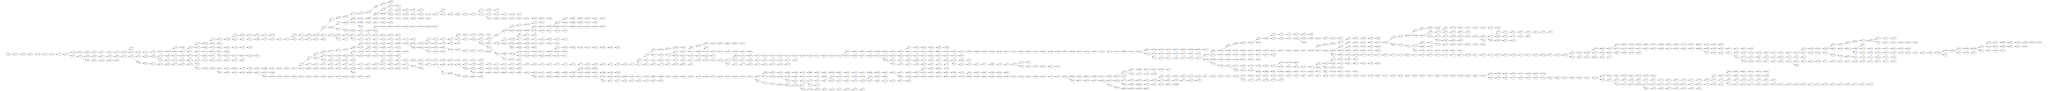

In [16]:
# Let's draw the orbit tree
def render_orbits(orbit_tree):
    g = gv.Digraph()
    for parent, children in orbit_tree.items():
        for child in children:
            g.edge(parent, child)
    return g

g = render_orbits(orbit_tree(day(6)))
g.attr(size='50', rankdir='LR')
g

The second part asks how many orbital transfers to get from the object YOU are orbiting to the object SAN is orbiting.

[['COM', 'B', 'C', 'D', 'I'], ['COM', 'B', 'G'], ['COM', 'B', 'G', 'H']]


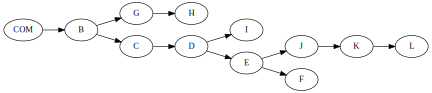

In [17]:
def transpose(tree):
    'Return the transposition of the supplied graph'
    return {c:p for p, children in tree.items() for c in children}

def root_to_node_paths(tree, *nodes):
    'Return the paths from the root of the tree to the nodes'
    transposed = transpose(tree)
    top = root(tree)
    def _path_to(node):
        return [top] if node == top else _path_to(transposed[node]) + [node]
    return [_path_to(n) for n in nodes]

# Check by inspecting output
orbits = orbit_tree(example_6)
print(root_to_node_paths(orbits, 'I', 'G', 'H'))
g = render_orbits(orbits)
g.attr(size='6', rankdir='LR')
g

In [18]:
example_6_part2 = '''\
COM)B
B)C
C)D
D)E
E)F
B)G
G)H
D)I
E)J
J)K
K)L
K)YOU
I)SAN'''

def orbital_transfers(tree, you='YOU', san='SAN'):
    # To find the number of orbital transfers between `you` and `san`
    # we find the paths from the root to these nodes
    # then find where these paths diverge.
    paths = root_to_node_paths(tree, you, san)
    diverge = next(i for i, (a, b) in enumerate(zip(*paths)) if a != b)
    return len(paths[0]) + len(paths[1]) - 2 * diverge - 2

assert orbital_transfers(orbit_tree(example_6_part2)) == 4
print('Day 6, part 2:', orbital_transfers(tree))

Day 6, part 2: 379


## [Day 7](https://adventofcode.com/2019/day/7): Amplification Circuit
Part one is an optimisation problem: we're asked to work out which input settings maximise the output. The puzzle input is an Intcode program, and the settings are a permutation of the numbers 0, 1, 2, 3, 4. We just run the program on all possible inputs.

In [19]:
def output_signal(prog, amp_settings):
    'Return the output signal resulting from the supplied settings.'
    in_ = 0
    for s in amp_settings:
        in_ = next(Intcode(prog, (s, in_)))
    return in_

example_7 = [3,15,3,16,1002,16,10,16,1,16,15,15,4,15,99,0,0]
assert output_signal(example_7, (4,3,2,1,0)) == 43210

def optimal_setting(prog, n=5):
    'Calculate the largest output signal for the program'
    return max(output_signal(prog, s)
               for s in its.permutations(range(n)))

assert optimal_setting(example_7) == 43210

assert optimal_setting((3,31,3,32,1002,32,10,32,1001,31,-2,31,1007,31,0,33,
1002,33,7,33,1,33,31,31,1,32,31,31,4,31,99,0,0,0)) == 65210

print('Day 7, part 1:', optimal_setting(ints(day(7))))

Day 7, part 1: 45730


Part two introduces a feedback loop. The initial settings are now a permutation of the ints 5, 6, 7, 8, 9. The program runs to completion.

In [20]:
def run_feedback_loop(prog, settings):
    'Run a feedback loop for amplifiers running `prog` on `settings`'
    coders = [Intcode(prog, [s]) for s in settings]
    coders[0].add_inputs(0) # Prime the loop
    for this, next_ in pairwise(its.cycle(coders)):
        out = next(this, None) # Grab the output from this coder
        if out is None:
            return prev        # No output => prev value is the signal
        prev = out
        next_.add_inputs(out)  # And use it as input to the next coder

example_7 = (3,26,1001,26,-4,26,3,27,1002,27,2,27,1,27,26,
27,4,27,1001,28,-1,28,1005,28,6,99,0,0,5)
assert run_feedback_loop(example_7, (9,8,7,6,5)) == 139629729

def max_thruster_signal(prog, settings):
    'Return the max signal possible for the supplied prog and settings'
    return max(run_feedback_loop(prog, s)
               for s in its.permutations(settings))

assert max_thruster_signal(example_7, range(5, 10)) == 139629729

print('Day 7, part 2:', 
      max_thruster_signal(tuple(ints(day(7))), range(5, 10)))

Day 7, part 2: 5406484


## [Day 8](https://adventofcode.com/2019/day/8): Space Image Format
We have an image encoded as a series of digits, each of which is a pixel colour. Pixels are arranged in layers. We are told the size of the image. 

For part one, find the layer containing the fewest 0 digits, and calculate -- for that layer -- the number of 1 digits x the number of 2 digits.

In [21]:
def solve_day8(im, w, h):
    # Count pixels on each layer
    layers = [cs.Counter(chunk) for chunk in chunked(im, w*h)]
    layer = min(layers, key=ops.itemgetter('0'))
    return layer['1'] * layer['2']

assert solve_day8('123456789012', 3, 2) == 1
print('Day 8, part 1:', solve_day8(day(8), 25, 6))

Day 8, part 1: 1452


For part two, we compose the layers to produce a binary image. The first layer is on top. The pixel colours are 2 - transparent, 0 - black, 1 - white.

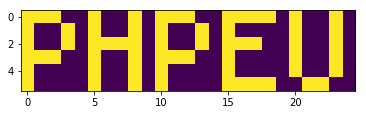

In [22]:
def full_image(im, w, h):
    layers = range(0, len(im), w*h)
    px = [int(d) for d in im]
    def colour(r, c):
        'Return the colour of pixel at (r, c)'
        pixels = (px[r*w + c + l] for l in layers)
        return next((p for p in pixels if p != 2), 0)
    return [[colour(r, c) for c in range(w)] for r in range(h)]

plt.imshow(full_image(day(8), 25, 6))

## [Day 9](https://adventofcode.com/2019/day/9): Sensor Boost
The Intcode computer must be extended to support parameters in relative mode. This is similar to positional mode, in that the parameter refers to a position. In relative mode, this position is counted from a _relative base_ which itself starts from zero and is adjusted via the _relative base offset_ instruction.

Happily this change is backwards compatible. I went back to my day 5 solution and added support for this mode.

In [23]:
example_9 = [109,1,204,-1,1001,100,1,100,1008,100,16,101,1006,101,0,99]
assert list(Intcode(example_9)) == example_9
assert next(Intcode((104,1125899906842624,99))) == 1125899906842624

print('Day 9, part 1:', next(Intcode(ints(day(9)), [1])))
%time print('Day 9, part 2:', next(Intcode(ints(day(9)), [2])))

Day 9, part 1: 3063082071
Day 9, part 2: 81348
Wall time: 1.76 s


## [Day 10](https://adventofcode.com/2019/day/10): Monitoring Station
Asteriods are centred on the `#` points on the map. They are small. We must build a monitoring station which has direct line of sight on the most asteroids. The station must itself be on an asteroid. We are asked to figure out where to put the station and calculate how many asteroids can be detected from it.

Again, let's use complex numbers to represent points in the 2D plane. If a group of asteroids subtend the same angle from the monitoring station, only the closest will be visible. So, grouping asteroid positions by this angle gives our answer.

In [24]:
def asteroid_positions(data):
    'Return the asteroid positions represented as complex numbers'
    return {c + r*1j 
            for r, row in enumerate(data.splitlines())
            for c, col in enumerate(row) if col=='#'}

def angle_from(a, b):
    'Return the angle from asteroid a to b'
    return cmath.phase(b-a)

def n_visible_from(a, asteroids):
    'How many asteroids can be seen from asteriod `a`?'
    return len({angle_from(a, b) for b in asteroids if b != a})

def monitoring_station(asteroids):
    'Return the best asteroid to use as a monitoring station'
    return max(((n_visible_from(a, asteroids), a) for a in asteroids),
               key=first)

example_10 = '''\
.#..#
.....
#####
....#
...##
'''

assert monitoring_station(asteroid_positions(example_10)) == (8, 3+4j)
n_vis, station = monitoring_station(asteroid_positions(day(10)))
print(f'Day 10, part 1: {n_vis} asteroids are visible from station {station}')

Day 10, part 1: 319 asteroids are visible from station (31+20j)


For part two, we install a laser at the monitoring station. This sweeps in a circle, vaporising one asteroid at a time. We're asked to find the 200th asteroid to be vaporised. If the laser strikes a row of asteroids, the closest is vaporised, and the next will be vaporised when the laser sweeps round again.

In [25]:
pi = math.pi

def sweep_angle(p, a):
    'Return the angle to `p` from `a`'
    d = p - a
    theta = cmath.phase(d)
    # Enure theta is in range [0, 2*pi]
    q3 = d.real < 0 and d.imag < 0
    return theta + 2.5 * pi if q3 else theta + 0.5 * pi

def vaporise(asteroids):
    'Generate the sequence of vaporised asteroids'
    # Group by sweep angle, then sort by distance from base
    _, base = monitoring_station(asteroids)
    targets = asteroids - {base}
    def theta(a): return sweep_angle(a, base)
    def R(a): return abs(a-base)
    sightlines = [sorted(g, key=R) for g in grouped(targets, theta)]
    return its.islice(
        (s.pop(0) for s in its.cycle(sightlines) if s),
        len(targets))

# Let's check the worked example
example_10_p2 = '''\
.#....#####...#..
##...##.#####..##
##...#...#.#####.
..#.....#...###..
..#.#.....#....##'''

positions = asteroid_positions(example_10_p2)
_, base = monitoring_station(positions)
vaped = vaporise(positions)
base_grid = {(0,0): ' ', (int(base.imag), int(base.real)): 'X'}
for i, chunk in enumerate(chunked(zip('123456789'*4, vaped), 9)):
    print(f'Vaporise group {i}')
    draw_grid(
        {**{(int(p.imag), int(p.real)):c for c,p in chunk}, 
        **base_grid})
    print('-'*32)

Vaporise group 0
         24     
        13 67  9
         5 8    
        X       
--------------------------------
Vaporise group 1
                 
                 
            1234 
        X   5    
    9     8    76
--------------------------------
Vaporise group 2
 8       
56   9   
34   7   
  2     X
  1      
--------------------------------
Vaporise group 3
      234     6  
      1   5     7
                 
        X    89  
--------------------------------


In [26]:
p = nth(vaporise(asteroid_positions(day(10))), 199)
print(f'Day 10, part 2: {int(100*p.real + p.imag)}')

Day 10, part 2: 517


## [Day 11](https://adventofcode.com/2019/day/11): Space Police
We're using a robot as input to an Intcode program. The robot is being directed by the output of this program.

In [27]:
def paint_hull(prog, start_colour=0):
    'Paint the hull using the intcode `prog`. Returns painted cells'
    pos, direction = 0, 1j
    hull = cs.defaultdict(int)
    hull[0] = start_colour
    intcoder = Intcode(prog, [start_colour])
    xs = []
    for colour, turn in chunked(intcoder, 2):
        if colour is None: break
        hull[pos] = colour
        direction *= -1j if turn else 1j
        pos += direction
        intcoder.add_inputs(hull[pos])
    return dict(hull)

# Part one asks how many cells the robot visits
print('Day 11, part 1:', len(paint_hull(ints(day(11)))))

Day 11, part 1: 1709


Part two tells us the start colour is in fact white (1) and asks what message the robot paints.

In [28]:
painted = paint_hull(ints(day(11)), start_colour=1)
draw_grid({(-int(c.imag), int(c.real)): ' #'[v] 
           for c, v in painted.items()}) 

 ###   ##  #  # #### #  #  ##    ## #  #   
 #  # #  # #  # #    #  # #  #    # #  #   
 #  # #    #  # ###  #### #       # ####   
 ###  # ## #  # #    #  # #       # #  #   
 #    #  # #  # #    #  # #  # #  # #  #   
 #     ###  ##  #### #  #  ##   ##  #  #   


## [Day 12](https://adventofcode.com/2019/day/12): The N-Body Problem
We have to perform some 3D calculations on 4 moons, Io, Europa, Ganymede, and Callisto, given their initial positions.

In [29]:
day_12 = '''\
<x=-13, y=14, z=-7>
<x=-18, y=9, z=0>
<x=0, y=-3, z=-3>
<x=-15, y=3, z=-13>'''

example_12 = '''\
<x=-1, y=0, z=2>
<x=2, y=-10, z=-7>
<x=4, y=-8, z=8>
<x=3, y=5, z=-1>'''

example_12_2 = '''\
<x=-8, y=-10, z=0>
<x=5, y=5, z=10>
<x=2, y=-7, z=3>
<x=9, y=-8, z=-3>'''

def moon_positions(moon_data):
    ps = [np.array(p, dtype=int) for p in array(moon_data)]
    M = range(len(ps))
    vs = [np.zeros(3, dtype=int) for _ in M]
    ij = list(its.combinations(M, 2))
    while True:
        yield ps, vs
        for i, j in its.combinations(M, 2):
            gravity = np.sign(ps[i] - ps[j])
            vs[i] -= gravity
            vs[j] += gravity
        for p, v in zip(ps, vs): p += v

def energy(position, velocity):
    return np.sum(np.abs(position)) * np.sum(np.abs(velocity))

# Part 1 asks for the energy at time 1000
# Check the worked example
assert sum(map(energy, *nth(moon_positions(example_12), 10))) == 179

# And calculate the solution
print('Day 10, part 1:', sum(map(energy, *nth(moon_positions(day_12), 1000))))

Day 10, part 1: 7138


Part two asks us how long before the universe state (i.e. positions and velocities) repeats. There's a warning this might take a very long time.

The optimisation here is to calculate the cycle times for the X, Y, Z coordinates independently. 

In [30]:
def cycle(xs):
    'How long before `xs` returns to initial state?'
    start = next(xs)
    return next(i for i, p in enumerate(xs, 1) if p==start)

def cycles(moon_data):
    return [
        cycle(tuple(p[i] for p in np.concatenate(pvs))
        for pvs in moon_positions(moon_data)) for i in range(3)]

assert lcm(*cycles(example_12)) == 2772
assert lcm(*cycles(example_12_2)) == 4686774924
%time print('Day 12, part 2:', lcm(*cycles(day_12)))

Day 12, part 2: 572087463375796
Wall time: 32.3 s


## [Day 13](https://adventofcode.com/2019/day/13): Care Package
An arcade cabinet runs Intcode software. The screen displays square tiles. The program outputs are `(x, y, tile)` triples.

We are asked to run the game and calculate how many blocks are on screen when the game exits.

In [31]:
def arcade_game(prog):
    return {(x, y): tile
        for x, y, tile in chunked(Intcode(prog, []), 3)}

EMPTY, WALL, BLOCK, BAT, BALL = range(5)
display = arcade_game(ints(day(13)))
cs.Counter(display.values())[BLOCK]

420

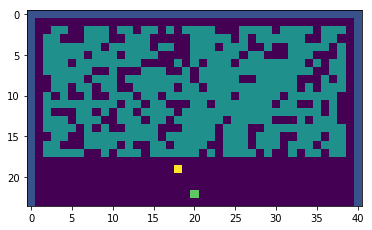

In [32]:
# Draw the display using matplotlib.
%matplotlib inline
xhi, yhi = max(display)
raster = [[display[(x,y)] for x in range(xhi+1)] for y in range(yhi+1)]
plt.imshow(raster)
plt.show()

For part two we set address `0` to value `2` to play for free. We then provide inputs `0`, `-1`, `1` to adjust the joystick so it moves the bat into the correct place to keep the ball in play.

Designing the robot player took a little bit of trail and error to figure out when the input values are read and the initial direction. I used the animation in the next cell to experiment.

In [33]:
def play_arcade_game(prog, W=xhi, H=yhi):
    ''' Play the arcade game
    
    W, H - the screen dimensions
    '''
    bat = ball = W # Track the X position of the bat and ball
    score = 0 
    display = [[0 for _ in range(W+1)] for _ in range(H+1)]
    game = Intcode([2] + list(prog[1:])) # address[0]=2 => play in free mode
    for x, y, v in chunked(game, 3):
        if (x, y) == (-1, 0):
            score = v
        else:
            display[y][x] = v
            if v == BAT:
                bat = x
            elif v == BALL:
                ball = x
                game.add_inputs(cmp(bat, ball)) # Move the bat towards the ball
        yield display, score

print('Final score:', last(score for _, score in play_arcade_game(ints(day(13)))))

Final score: 21651


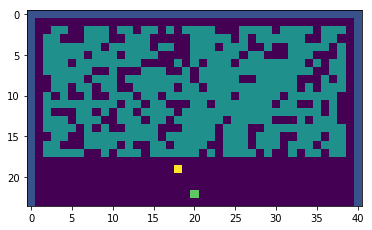

In [34]:
from matplotlib import animation, rc
from IPython.display import HTML

frames = play_arcade_game(ints(day(13)))
frames = its.islice(frames, (xhi+1)*(yhi+1)-1, None) # Don't animate display setup
fig = plt.figure()
im = plt.imshow(next(frames)[0])

def next_frame(i):
    im.set_data(next(frames)[0])
    return (im,) # Careful! Must return an iterable

anim = animation.FuncAnimation(fig, next_frame, frames=20000, interval=20)

In [35]:
# HTML(anim.to_jshtml()) # Don't do this for run all cells, it's expensive

In [36]:
# HTML(anim.to_html5_video()) # Don't do this for run all cells, it's expensive

`anim.save('day13.mp4')` # [Here's one I made earlier](./day13.mp4)

## [Day 14](https://adventofcode.com/2019/day/14): Space Stoichiometry
We're asked to produce FUEL efficiently, given a list of ingredients. We start from ORE. Each line of the input gives a chemical reaction, showing how to combine elements to produce an output.

In [37]:
example_14 = '''\
10 ORE => 10 A
1 ORE => 1 B
7 A, 1 B => 1 C
7 A, 1 C => 1 D
7 A, 1 D => 1 E
7 A, 1 E => 1 FUEL'''

def parse_rule(rule):
    *ingredients, target = [
        (int(n), w) for n, w in re.findall(r'(\d+) (\w+)', rule)]
    return ingredients, target

def reaction_graph(rules):
    return {
        name: (count, ingreds)
        for ingreds, (count, name) in map(parse_rule, rules.splitlines())}

reaction_graph(example_14)

{'A': (10, [(10, 'ORE')]),
 'B': (1, [(1, 'ORE')]),
 'C': (1, [(7, 'A'), (1, 'B')]),
 'D': (1, [(7, 'A'), (1, 'C')]),
 'E': (1, [(7, 'A'), (1, 'D')]),
 'FUEL': (1, [(7, 'A'), (1, 'E')])}

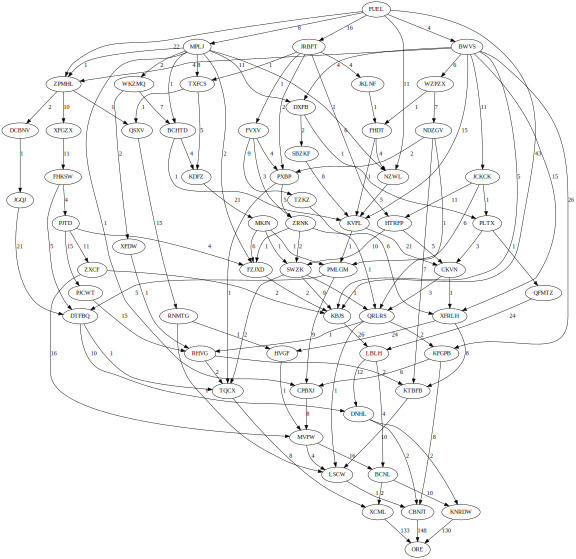

In [38]:
# Let's render the reaction graph using Graphviz
def reaction_graphviz(reactions):
    g = gv.Digraph()
    for target, (_, ingredients) in reactions.items():
        g.node(target)
        for n, i in ingredients:
            g.node(i)
            g.edge(target, i, label=str(n))
    return g

g = reaction_graphviz(reaction_graph(day(14)))
g.attr(size='8,8')
g

In [39]:
def produce_fuel(g, amount=1, base='ORE'):
    'Return # of `base` units required to produce `amount` of top node'
    # Use a 
    nodes = topological_sort({k: {i for _, i in v} 
                              for k, (_, v) in g.items()})
    required = cs.defaultdict(int, {nodes[0]: amount})
    for node in nodes:
        amount = required[node]
        if node == base:
            return amount
        batch_size, ingredients = g[node]
        batches = (amount + batch_size - 1) // batch_size
        for count, ingredient in ingredients:
            required[ingredient] += batches * count

assert produce_fuel(reaction_graph(example_14)) == 31

In [40]:
example_14_2 = '''\
9 ORE => 2 A
8 ORE => 3 B
7 ORE => 5 C
3 A, 4 B => 1 AB
5 B, 7 C => 1 BC
4 C, 1 A => 1 CA
2 AB, 3 BC, 4 CA => 1 FUEL'''

assert produce_fuel(reaction_graph(example_14_2)) == 165
print('Day 14, part 1:', produce_fuel(reaction_graph(day(14))))

Day 14, part 1: 1037742


Part two asks how much fuel we can produce if we start with 1 trillion units of ore. We can do a binary search.

In [41]:
example_14_3 = '''\
157 ORE => 5 NZVS
165 ORE => 6 DCFZ
44 XJWVT, 5 KHKGT, 1 QDVJ, 29 NZVS, 9 GPVTF, 48 HKGWZ => 1 FUEL
12 HKGWZ, 1 GPVTF, 8 PSHF => 9 QDVJ
179 ORE => 7 PSHF
177 ORE => 5 HKGWZ
7 DCFZ, 7 PSHF => 2 XJWVT
165 ORE => 2 GPVTF
3 DCFZ, 7 NZVS, 5 HKGWZ, 10 PSHF => 8 KHKGT'''

def how_much_fuel(g, ore=1_000_000_000_000):
    lo, hi = 1, 1
    while produce_fuel(g, hi) < ore:
        lo, hi = hi, hi + hi
    return binary_search(lo, hi, lambda m: produce_fuel(g, m) > ore)

assert how_much_fuel(reaction_graph(example_14_3)) == 82892753
print('Day 14, part 2:', how_much_fuel(reaction_graph(day(14))))

Day 14, part 2: 1572358


## [Day 15](https://adventofcode.com/2019/day/15): Oxygen System
Another Intcode program. We're operating a repair droid. The movement commands are inputs north (1), south (2), west (3), and east (4). Status is reported by the output:
- 0: The repair droid hit a wall. Its position has not changed.
- 1: The repair droid has moved one step in the requested direction.
- 2: The repair droid has moved one step in the requested direction; its new position is the location of the oxygen system.

For part 1 we must find the shortest number of commands to locate the oxygen system.

To solve this, let's use a breadth first search of the floor. We can launch multiple droids to do this.

To solve this, I revisited my Intcode computer and add support for forking a program: that is, creating a copy of the program with the same code, memory, state.

In [42]:
NSWE = {1j: 1, -1j: 2, -1: 3, 1: 4}
WALL, MOVE, O2 = range(3)

class Droid:
    def __init__(self, prog):
        self.prog = prog

    def step(self, d):
        self.prog.add_inputs(NSWE[d])
        return next(self.prog)
    
    def clone(self):
        return Droid(self.prog.fork())


def explore(prog):
    '''Breadth-first exploration of the spaceship
    
    - prog: the droid control Intcode program. 
            Input direction, Output WALL, MOVE, O2
    
    Yields the floor-plan known after each step
    '''
    fringe, plan = {0: Droid(Intcode(prog))}, {0: ' '}
    
    while fringe:
        yield plan
        for p in set(fringe):
            steps = [d for d in NSWE if p+d not in plan]
            for d in steps:
                droid = fringe[p].clone()
                output = droid.step(d)
                if output != WALL:
                    fringe[p+d] = droid
                plan[p+d] = '# O'[output]
            fringe.pop(p)

next(d for d, plan in enumerate(explore(ints(day(15))))
     if 'O' in plan.values())

330

For part two, the robot repairs the oxygen system and we are asked how long it takes for oxygen to fill the area. Oxygen spreads through the spaceship breadth first.

In [43]:
def fill_with_oxygen(plan):
    'Returns the time taken for oxygen to fill the plan'
    fringe = {next(p for p, v in plan.items() if v=='O')}
    for t in its.count():
        fringe = {
            f+d for f in fringe 
                for d in NSWE if plan[f+d]==' '} - fringe
        plan.update((f, 'O') for f in fringe)
        if not fringe: return t

plan = last(explore(ints(day(15))))
fill_with_oxygen(plan)

352

## [Day 16](https://adventofcode.com/2019/day/16): Flawed Frequency Transmission
A signal is repeatedly transformed by a matrix operation. Rows of the matrix are patterns of zeros or ones. Finally, the result is taken modulo 10. For part one we transform the input signal 100 times.

In [44]:
def pattern(n, N):
    p = its.cycle([0]*n + [1]*n + [0]*n + [-1]*n)
    return list(its.islice(p, 1, N+1))

def phases(signal):
    N = len(signal)
    fft = np.array([pattern(n, N) for n in range(1, N+1)], 'int')
    while True:
        yield signal
        signal = np.abs(fft @ signal) % 10
    

example_16 = nth(phases(np.array(range(1, 9), 'int')), 4)
assert cat(map(str, example_16)) == '01029498'

day_16 = np.array([int(d) for d in day(16)], 'int')
# After 100 phases of FFT, what are the first eight digits 
# in the final output list?
print('Day 16, part 1:', cat(map(str, nth(phases(day_16), 100)))[:8])

Day 16, part 1: 30379585


Part two tells us the real signal is your puzzle input repeated 10000 times. The transformation is as before, and again we apply it 100 times.

We are asked for the eight digit sequence at an offset into the final signal. That offset is given by the first seven digits of the initial signal.

In [45]:
offset = int(day(16)[:7])
print('Input length', len(day(16))*10_000, 'offset', offset)

Input length 6500000 offset 5975803


The FFT matrix is upper-triangular. The bottom half of this triangle is all 1's. Thus the tail signal is an accumulation we can calculate bottom up.

In [46]:
signal = day(16) * 10_000

# Reverse the tail of the signal
tail = [int(d) for d in signal[:offset-1:-1]]

# FFT 100 times
for _ in range(100):
    tail = [d % 10 for d in its.accumulate(tail)]

# And we're after the first 8 digits of the result
print('Day 16, part 2:', cat(map(str, tail[:-9:-1])))

Day 16, part 2: 22808931


## [Day 17](https://adventofcode.com/2019/day/17): Set and Forget
Another Intcode program, in this case providing access to the cameras and vacuum robot. We start by drawing the scaffolding and the initial position of the robot.

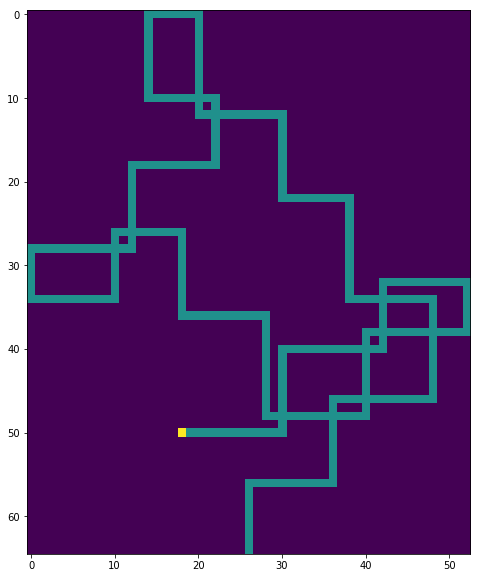

In [47]:
scaffold = cat(map(chr, Intcode(ints(day(17)))))
raster = [[{'.':0,'#':1}.get(c, 2) for c in row] for row in scaffold.split()]
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(raster)
plt.show()

In [48]:
example_17 = '''\
..#..........
..#..........
#######...###
#.#...#...#.#
#############
..#...#...#..
..#####...^..'''

def alignment(scaffold):
    grid = {(x, y): c 
        for y, row in enumerate(scaffold.split())
        for x, c in enumerate(row)}
    intersections = (
        p for p in grid
        if all(grid.get(q)=='#' for q in {p}|set(neighbours4(*p))))
    return sum(x*y for x, y in intersections)
    
assert alignment(example_17) == 76
print(alignment(scaffold))

12512


For part two, set address zero from 1 to 2. Then supply a main movement routine to control the robot. This routine calls functions A, B, C. The functions A, B, C are L, R, N sequences, where L, R are turns and N is a number..  

In [49]:
example_17_2 = '''\
#######...#####
#.....#...#...#
#.....#...#...#
......#...#...#
......#...###.#
......#.....#.#
^########...#.#
......#.#...#.#
......#########
........#...#..
....#########..
....#...#......
....#...#......
....#...#......
....#####......'''

def scaffold_path(scaffold):
    ''' Returns the scaffolding route
    
    Returns a list of R, L, <N> instructions which 
    turn or advance the scaffolding robot.
    '''
    grid = { 
        x+y*1j : c 
        for y,row in enumerate(scaffold.split())
        for x,c in enumerate(row)
    }
    p = next(p for p, v in grid.items() if v in '^v><')
    d = {'^':-1j, 'v':1j, '>':1, '<':-1}[grid[p]]
    run, path = 0, []

    while True:
        turn = next((turn for turn in (1,1j,-1j) 
                     if grid.get(p + d*turn) == '#'), 0)
        if turn == 0:
            return path + [run]
        elif turn == 1:
            run += 1
        else:
            if run: path.append(run)
            path.append({1j: 'R', -1j: 'L'}[turn])
            run = 1
            d *= turn
        p += d

day17_2 = [2] + list(ints(day(17))[1:])

code = ','.join(map(str, scaffold_path(example_17_2)))
assert code == 'R,8,R,8,R,4,R,4,R,8,L,6,L,2,R,4,R,4,R,8,R,8,R,8,L,6,L,2'
steps = scaffold_path(cat(map(chr, Intcode(ints(day(17))))))
','.join(map(str, steps))

'R,12,L,10,R,12,L,8,R,10,R,6,R,12,L,10,R,12,R,12,L,10,R,10,L,8,L,8,R,10,R,6,R,12,L,10,R,10,L,8,L,8,R,10,R,6,R,12,L,10,R,10,L,8,R,12,L,10,R,12,R,12,L,10,R,10,L,8'

In [50]:
# I got this decomposition by trial and error
','.join(map(str, steps)
        ).replace('R,12,L,10,R,10,L,8', 'A'
        ).replace('R,12,L,10,R,12', 'B'
        ).replace('L,8,R,10,R,6', 'C')

'B,C,B,A,C,A,C,A,B,A'

The actual input is the `main` program, then subroutines `A`, `B`, `C`, all followed by newlines, and finally `y` or `n` followed by a newline to configure the video feed. Remember, the input for part two has a 2 in address zero.

In [51]:
day17_inputs = [ord(c) for c in '''\
B,C,B,A,C,A,C,A,B,A
R,12,L,10,R,10,L,8
R,12,L,10,R,12
L,8,R,10,R,6
n
''']

last(Intcode(day17_2, day17_inputs))

1409507

## [Day 18](https://adventofcode.com/2019/day/18): Many-Worlds Interpretation
We have to traverse a 2D grid of walls (`#`), passages (`.`) and doors (`[A-Z]`). A door `D` requires key `d` to open it, and we're asked to collect all keys in the shortest time.

In [52]:
# Try an A-star search.
# State is position + keys held (as a string)
def find_keys(grid_data):    
    grid = {
        (x,y): c for y, row in enumerate(grid_data.split())
                 for x, c in enumerate(row)
    }
    n_keys = sum(c.islower() for c in grid.values())
    
    def heuristic(state):
        _, keys = state
        return n_keys - len(keys) # Number of keys left

    def moves(state):
        p, keys = state
        for q in neighbours4(*p):
            c = grid.get(q, '#')
            if c in '.@' or c.lower() in keys: yield q, keys
            elif c.islower(): yield q, cat(sorted(keys + c))

    start = next(p for p, v in grid.items() if v=='@'), ''
    return a_star(start, heuristic, moves=moves)

example_18 = '''\
#########
#b.A.@.a#
#########'''

assert find_keys(example_18)[0] == 8

example_18_2 = '''\
########################
#f.D.E.e.C.b.A.@.a.B.c.#
######################.#
#d.....................#
########################'''

assert find_keys(example_18_2)[0] == 86

%time print('Part one:', find_keys(day(18))[0])

Part one: 7430
Wall time: 49.1 s


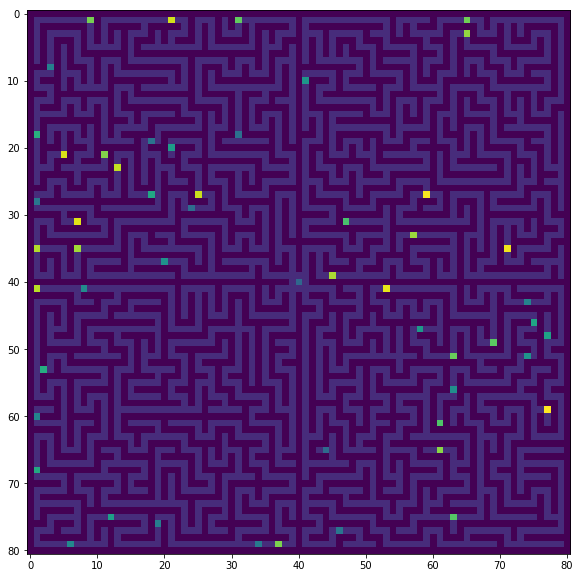

In [53]:
raster = [[ord(c) for c in row] for row in day(18).splitlines()]
plt.imshow(raster)
plt.show()

For part two, we update the grid, replacing the central area:

```
...         @#@
.@.     =>  ###
...         @#@
```

We now have 4 starting positions for 4 independent traversals of the grid quadrants. Initially, I extended the solution for part one to have as state the robot positions and keys held, but this did not run in a reasonable amount of time. I rewrote my solution to move to accessible keys at each step, using [networkx](https://networkx.github.io/) to precalculate the shortest paths between keys and the doors on these paths.

In [54]:
is_key = str.islower
is_door = str.isupper

def is_start(c): return c=='@'
def is_wall(c): return c=='#'
def is_open(door, keys): return door.lower() in keys

def load_grid(grid_data):
    return {(x,y): c for y, row in enumerate(grid_data.split())
                     for x, c in enumerate(row)}

def split_grid(grid):
    ''' Splits a grid
    
    The central @ is replaced:
    ...         @#@
    .@.     =>  ###
    ...         @#@
    '''
    m = next(p for p, v in grid.items() if is_start(v))
    grid.update((n, '@') for n in neighbours8(*m))
    grid.update((n, '#') for n in its.chain(neighbours4(*m), [m]))
    return grid

example_18_part2 = '''\
#######
#a.#Cd#
##...##
##.@.##
##...##
#cB#Ab#
#######'''

example_18_part2_2 = '''\
###############
#d.ABC.#.....a#
######...######
######.@.######
######...######
#b.....#.....c#
###############'''

def paths_between_keys(grid):
    ''' Calculate shortest paths between keys/start positions in grid.
    
    Returns a graph whose nodes are key/start positions, edges
    are the shortest paths between those positions, labeled
    with the doors on that path.
    '''
    def doors(path):
        return cat(grid[v] for v in path if is_door(grid[v]))

    G = graph_from_edges((p, n) 
        for p in grid if not is_wall(grid[p])
        for n in neighbours4(*p) if not is_wall(grid[n]))
    
    vs = {p for p, v in grid.items() if is_key(v) or is_start(v)}
    return graph_from_edges(
        (v, w, {'weight': len(p)-1, 'doors': doors(p)})
        for v, w in its.combinations(vs, 2)
        for p in shortest_paths(G, v, w))
    
def find_keys(grid):
    '''Find the keys in the grid, using a robot at each start pos
    
    Runs an A-star search, returning a (steps, shortest_path) pair
    '''
    n_keys = sum(is_key(c) for c in grid.values())
    ps = tuple([p for p, c in grid.items() if is_start(c)])
    paths = paths_between_keys(grid)

    def heuristic(state):
        'A-star heuristic: the number of keys to collect'
        _, keys = state
        return n_keys - len(keys)

    def do_move(k, keys, doors):
        'Can we move to key `k` if we hold `keys` and pass `doors`?'
        return (not is_start(k) and k not in keys and 
                all(is_open(d, keys) for d in doors))
    
    def moves(state):
        'Generate the `(new_state, cost)` neighbours of `state`'
        # We proceed to accessible keys
        ps, keys = state
        yield from (
            ((ps[:i] + (K,) + ps[i+1:], cat(sorted(keys+grid[K]))), label['weight'])
            for i, k in enumerate(ps)
            for K, label in paths[k].items() 
            if do_move(grid[K], keys, label['doors']))

    return a_star((ps, ''), heuristic, costed_moves=moves)

assert find_keys(split_grid(load_grid(example_18_part2)))[0] == 8
assert find_keys(split_grid(load_grid(example_18_part2_2)))[0] == 24
%time print('Day 18, part one:', find_keys(load_grid(day(18)))[0])
%time print('Day 18, part two:', find_keys(split_grid(load_grid(day(18))))[0])

Day 18, part one: 7430
Wall time: 10.1 s
Day 18, part two: 1864
Wall time: 6.9 s


## [Day 19](https://adventofcode.com/2019/day/19): Tractor Beam

In [55]:
pts = [next(Intcode(ints(day(19)), p)) 
    for p in its.product(range(50), repeat=2)]

print('Day 19, part 1:', sum(pts))

Day 19, part 1: 181


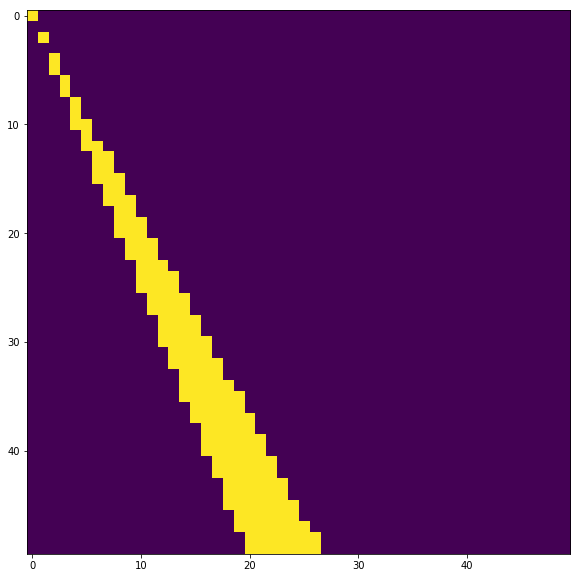

In [56]:
pt = iter(pts)
raster = list(zip(*[[next(pt) for _ in range(50)] for _ in range(50)]))
plt.imshow(raster)
plt.show()

This graphic demonstrates the Intcode program for day 19 does indeed generate a beam. Part 2 asks us to find the top left corner of an axis-aligned square which fits entirely within the beam. We can do this via a double application of binary search.

In [57]:
def day19_part_2(prog, W=100):
    def in_beam(x, y):
        'Return True iff `(x, y)` in the beam'
        return bool(next(Intcode(prog, (x, y))))

    def approx_gradient():
        'Return the approximate gradient of the beam'
        xs = (x * next(Intcode(prog, (x, 100)))
              for x in range(101))
        return 100/statistics.mean(x for x in xs if x > 0)

    approx_m = approx_gradient()
    
    def top_y_at_x(x):
        return 1 + binary_search(
            0, int(approx_m * x), lambda y: in_beam(x, y))
    
    def square_fits_at_x(x):
        ''' Does a square region fit the beam?
        
        x - the coord of the righthand edge
        
        Returns `(TF, (x, y))` where TF is True iff the square fits
        and `(x, y)` is the top-right of the square.
        '''
        y = top_y_at_x(x)
        # We arranged the top-right to be within the beam
        # If the bottom left is too, the square fits.
        return in_beam(x-W+1, y+W-1)
    
    xlo, xhi = 1, 1
    while not square_fits_at_x(xhi):
        xlo, xhi = xhi, xhi + xhi
    
    x = binary_search(xlo, xhi, square_fits_at_x) + 1
    y = top_y_at_x(x)
    return x - W + 1, y

prog = ints(day(19))
x, y = day19_part_2(prog)
print('Day 19, part 2:', x * 10000 + y)

Day 19, part 2: 4240964


## [Day 20](https://adventofcode.com/2019/day/20): Donut Maze
We're given a donut shaped maze to traverse. There are "portals" which connect the inner/outer edges of the donut. So, in the example below, **BC** on the outside and **BC** on the inside are directly connected. We can take advantage of these portals to find the fastest route from **AA** to **ZZ**, our challenge for part 1.

Note: I initially implemented the approach shown by hand, but made mistakes. I switched to [Networkx](https://networkx.github.io/documentation/stable/index.html) with good results.

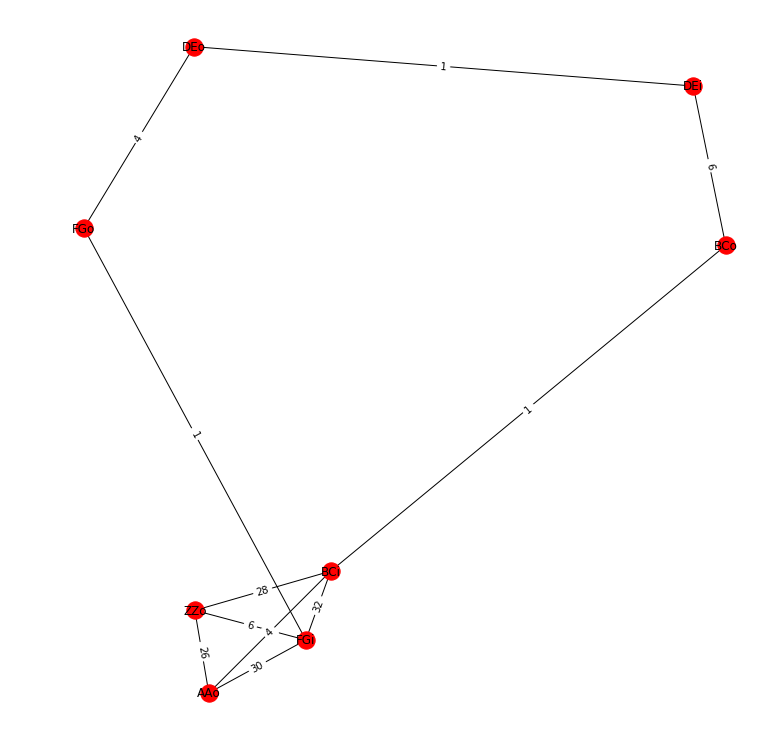

In [58]:
example_20 = '''\
         A           
         A           
  #######.#########  
  #######.........#  
  #######.#######.#  
  #######.#######.#  
  #######.#######.#  
  #####  B    ###.#  
BC...##  C    ###.#  
  ##.##       ###.#  
  ##...DE  F  ###.#  
  #####    G  ###.#  
  #########.#####.#  
DE..#######...###.#  
  #.#########.###.#  
FG..#########.....#  
  ###########.#####  
             Z       
             Z       '''

def donut_maze(maze_data):
    pts = {(y,x):c for y, row in enumerate(maze_data.splitlines())
                    for x, c in enumerate(row)}
    dots = {p for p, c in pts.items() if c=='.'}

    G = graph_from_edges((p,n) 
        for p in dots for n in set(neighbours4(*p)) & dots)

    # Find the corners of the rectangular outer torus
    wall = {p for p, c in pts.items() if c=='#'}
    (t, l), (b, r) = min(wall), max(wall)

    def label(y, x):
        'Return the label for `(y,x)`, or None'
        io = 'o' if y in {t, b} or x in {l, r} else 'i' # i/o denotes in/outside
        if pts[(y-1,x)].isupper(): return pts[(y-2,x)]+pts[(y-1,x)]+io
        if pts[(y+1,x)].isupper(): return pts[(y+1,x)]+pts[(y+2,x)]+io
        if pts[(y,x-1)].isupper(): return pts[(y,x-2)]+pts[(y,x-1)]+io
        if pts[(y,x+1)].isupper(): return pts[(y,x+1)]+pts[(y,x+2)]+io

    labels = {label(*p): p for p in dots if label(*p)}
    # We're only interested in paths between labels.
    # Create new graph, P, edge weight (b, e) := distance (b, e)
    path_lens = dict(nx.all_pairs_shortest_path_length(G))

    def path_len(b, e):
        return (1 if b.replace('o', 'i')==e else 
                path_lens.get(labels[b], {}).get(labels[e]))
    
    return graph_from_edges(
        (b, e, {'weight': path_len(b, e)})
        for b, e in its.permutations(labels, 2) if path_len(b, e))

def draw_maze(G):
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

G = donut_maze(example_20)
draw_maze(G)
assert nx.shortest_path_length(G, 'AAo', 'ZZo', weight='weight') == 23

Wall time: 4.75 s
Day 20, part 1: 464
Wall time: 999 µs


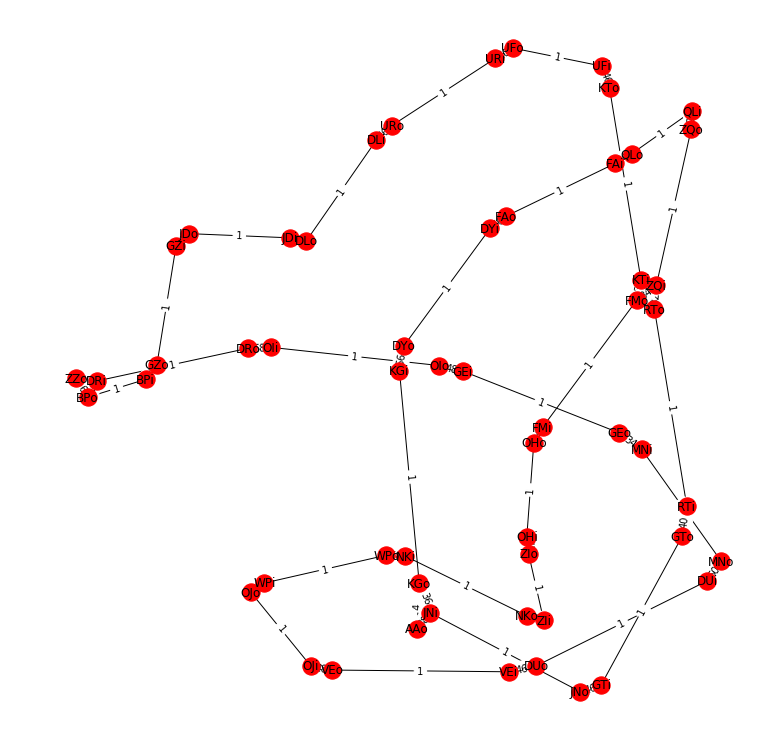

In [59]:
%time G20 = donut_maze(day(20))
draw_maze(G20)
%time print('Day 20, part 1:', nx.shortest_path_length(G20, 'AAo', 'ZZo', weight='weight'))

Part two reinterprets the maze. The maze data is recursive: gaps on inner edges connect to the corresponding outside gaps of an inner copy of the same maze.

Again, we are asked how many steps it takes to get from AA to ZZ. Traversing a level takes a single step.

In [60]:
def recursive_maze(maze, depth):
    def deep_edge(d, b, e, w):
        'Creates edge `(b, e)`, weight `w` at depth `d`'
        if w is 1: # A portal: link inside level d to outside d+1
            p = e.rstrip('io')
            return f'{p}i{d}', f'{p}o{d+1}', {'weight':w}
        else:         # Copy the edge to level d
            return f'{b}{d}', f'{e}{d}', {'weight':w}
    return graph_from_edges(
        deep_edge(d, *e) 
        for d in range(depth)
        for e in maze.edges.data('weight'))

G = recursive_maze(donut_maze(example_20), 2)
assert nx.shortest_path(G, 'AAo0', 'ZZo0', weight='weight') == ['AAo0', 'ZZo0']
example20_3 = open('input/example20_3').read()
G = recursive_maze(donut_maze(example20_3), 12)
assert nx.shortest_path_length(G, 'AAo0', 'ZZo0', weight='weight') == 396

# Recurse a level for every portal
G = recursive_maze(G20, len(G20)//2)

%time print('Day 20, part 2:', nx.shortest_path_length(G, 'AAo0', 'ZZo0', weight='weight'))

Day 20, part 2: 5802
Wall time: 4 ms


## [Day 21](https://adventofcode.com/2019/day/21): Springdroid Adventure

Springdroid programs:
* use boolean values
* have two registers, `T` and `J` (temp and jump) which start as `False`
* have a sensor capable of detecting ground 1, 2, 3 and 4 tiles away (A, B, C and D respectively)
* have 3 instructions `AND`, `OR`, `NOT` which operate on two registers, setting the second
* can be a maximum of 15 instructions

In [61]:
day_21 = ints(day(21))

def springdroid(instructions, command='WALK'):
    'Execute the instructions, returning the hull on failure, the damage on success'
    prog = f'{instructions}\n{command}\n'
    output = list(Intcode(day_21, [ord(c) for c in prog]))
    if output[-1] in range(128):
        lines = cat(chr(o) for o in output).splitlines()
        return lines[10]
    else:
        return output[-1]

def springdroid_walk(instructions):
    return springdroid(instructions, 'WALK')

I ran the program with various inputs to figure out how the springdroid behaved. I discovered:

- the program runs on every step based on current terrain
- the springdroid jumps a distance of 4
- the hull has multiple holes

In [62]:
springdroid_walk('NOT A J') # jump if there's a hole immediately ahead

'#####.#..########'

In [63]:
springdroid_walk('OR C T\nAND A T\nNOT T J') # jump if there's a hole 3 or 1 ahead 

'#####...#########'

In [64]:
# Jump if land 4 ahead and hole 3 or 1 ahead
springdroid_walk('OR D T\nNOT C J\nAND J T\nNOT A J\nOR T J')

19354818

So, the solution to part one is 19354818.

Part two introduces _extended sensor mode_, with registers E, F, G, H, I. This mode is enabled by the command `RUN`. Again, we're asked to survey the hull. 

In [65]:
def springdroid_run(instructions):
    return springdroid(instructions, 'RUN')

springdroid_run('OR D T\nNOT C J\nAND J T\nNOT A J\nOR T J') # It worked for part one

'#####.#.##...####'

In [66]:
# Try a new approach. Set the instructions to be D AND NOT (X AND Y AND ...) 
# where X, Y ... are the registers A, B, C, E, F, G, H, I
set(springdroid_run(ncat(['NOT T T'] + [f'AND {h} T' for h in holes] + ['NOT T T', 'AND D T', 'OR T J']))
    for holes in powerset('ABCEFGHI'))

{'#####.###########',
 '#####.#.#########',
 '#####.#.##...####',
 '#####.#..########',
 '#####..#.########'}

In [67]:
springdroid_run('OR C T\nOR E T\nNOT T T\nAND H T\nOR B J\n'
                'OR E J\nNOT J J\nOR J T\nNOT A J\nOR T J\nAND D J')

'#####..##..#..###'

In [68]:
# I had a few false attempts before getting to this final version
springdroid_run('OR C T\nOR E T\nNOT T T\nAND H T\nOR B J\n'
                'OR E J\nNOT J J\nOR J T\nNOT A J\nOR T J\nOR E J\nAND D J')

1143787220

## [Day 22](https://adventofcode.com/2019/day/22): Slam Shuffle
We have a deck of cards numbered 0, 1, 2 ... 10006. There are 3 different shuffling techniques:
- deal into new stack
- cut N cards
- deal with increment N

In [69]:
def deal_with_increment(xs, N):
    M = len(xs)
    ys = xs.copy()
    for i, x in zip(its.count(0, N), xs):
        ys[i % M] = x
    xs.clear()
    xs.extend(ys)

def shuffle(pack, instructions):
    for line in instructions.splitlines():
        N = ints(line)
        if line.startswith('deal into'):
            pack.reverse()
        elif line.startswith('deal with'):
            deal_with_increment(pack, N[0])
        else:
            pack.rotate(-N[0])

pack = cs.deque(range(10007))
shuffle(pack, day(22))
print('Day 22, part 1:', pack.index(2019))

Day 22, part 1: 3749


For part two, we start with a pack of 119315717514047 cards! And we shuffle it 101741582076661 times!! Which card ends up in position 2020?

In [70]:
def is_prime(n):
    r = 2
    while r * r < n:
        if n % r == 0:
            return False
        r += 1
    return True

P, S = 119315717514047, 101741582076661
is_prime(P), is_prime(S)

(True, True)

The first trick for part 2 is to realise that each instruction can be expressed as a linear transform `x → ax + b`, where `x` is the position of card `x`. The composition of two linear transforms is itself a linear transform, so a single shuffle is itself a linear transform. 

The values of `a` and `b` are:

- `-1, -1` for deal into 
- `n, 0` for deal with increment `n`
- `1, -n` for cut `n`

In [72]:
def shuffle(P, instructions):
    ''' Return the multiplier and constant a, b for the instructions
    
    P is the pack length
    '''
    A, B = 1, 0
    for line in instructions.splitlines():
        N = ints(line)
        if line.startswith('deal into'):
            a, b = -1, -1
        elif line.startswith('deal with'):
            a, b = N[0], 0
        else:
            a, b = 1, -N[0]
        A = (a * A) % P
        B = (a * B + b) % P
    return A, B

def inverse(x, p):
    ''' Return 1/x mod p, where p is prime '''
    # Fermats little theorem: pow(a, p-1) = 1 (mod p)
    return pow(x, p-2, p) # Note 3rd arg to pow!

a, b = shuffle(P, day(22))

# Now, to shuffle S times is a linear transform Sa, Sb 
Sa = pow(a, S, P)
Sb = (b * (Sa - 1) * inverse(a-1, P)) % P

# What ends up at 2020?
((2020 - Sb) * inverse(Sa, P)) % P

77225522112241

## [Day 23](https://adventofcode.com/2019/day/23): Category Six
We have the Intcode program for a NIC. We construct 50 computers each running this NIC. The computers are assigned addresses, 0, 1, ..., 49. They will then communicate by sending and receiving _packets_, which are `(X, Y, A)` triples, where A is a network address.

Once again I had to go back and modify my Intcode computer, this time to yield if an input is required but none are available.

In [73]:
def network(prog, N=50):
    natXY = None
    computers = [Intcode(prog, [n]) for n in range(N)]
    while True:
        idle = True
        for computer in computers:
            address = next(computer)
            if address is None:
                computer.add_inputs(-1) # The computer is idling and requires input
            else:
                idle = False # The computer outputs an (Address, X, Y) packet. 
                XY = next(computer), next(computer)
                # Dispatch based on address
                if address in range(N):
                    computers[address].add_inputs(*XY)
                elif address == 255:
                    natXY = XY

        if idle and natXY is not None: # All computers idle => ping computer 0
            yield natXY[1]
            computers[0].add_inputs(*natXY)

print('Day 23, part 1:', next(network(ints(day(23)))))
print('Day 23, part 2:', next(repeated(network(ints(day(23))))))

Day 23, part 1: 22151
Day 23, part 2: 17001


## [Day 24](https://adventofcode.com/2019/day/24): Planet of Discord
This looks like a [Game of Life](http://wordaligned.org/life) style cellular automaton.
A 5x5 grid is populated with bugs `#` and spaces `.`. Each minute, the bugs live and die based on the number of bugs in the four adjacent tiles:
- A bug dies (becoming an empty space) unless there is exactly one bug adjacent to it.
- An empty space becomes infested with a bug if exactly one or two bugs are adjacent to it.
- Otherwise, no change

We are asked to find the first repeated layout, and calculate the *biodiversity rating* of this layout.

In [74]:
day24 = '''\
##.#.
.#.##
.#...
#..#.
.##..'''

example24 = '''\
....#
#..#.
#..##
..#..
#....'''

def load_bugs(data):
    return {(y,x) for y, r in enumerate(data.splitlines())
                  for x, c in enumerate(r) if c=='#'}

def evolve(bugs):
    def is_a_bug(b):
        n_bugs = len(set(neighbours4(*b)) & bugs)
        return n_bugs==1 or n_bugs==2 and b not in bugs
    while True:
        yield bugs
        bugs = {b for b in its.product(range(5), repeat=2)
                if is_a_bug(b)}

def first_repeat(data):
    seen = set()
    for bugs in evolve(load_bugs(data)):
        hashed = frozenset(bugs)
        if hashed in seen:
            return bugs
        seen.add(hashed)

def biodiversity(bugs):
    return sum(2**(5*y + x) for y, x in bugs)

assert biodiversity(first_repeat(example24)) == 2129920
print('Day 24, part 1:', biodiversity(first_repeat(day24)))

Day 24, part 1: 17321586


Part two explains the grid is recursive. Each layer forms a smaller central of an outer layer, and has as its centre a smaller inner layer. 
```
     |     |         |     |     
  1  |  2  |    3    |  4  |  5  
     |     |         |     |     
-----+-----+---------+-----+-----
     |     |         |     |     
  6  |  7  |    8    |  9  |  10 
     |     |         |     |     
-----+-----+---------+-----+-----
     |     |A|B|C|D|E|     |     
     |     |-+-+-+-+-|     |     
     |     |F|G|H|I|J|     |     
     |     |-+-+-+-+-|     |     
 11  | 12  |K|L|?|N|O|  14 |  15 
     |     |-+-+-+-+-|     |     
     |     |P|Q|R|S|T|     |     
     |     |-+-+-+-+-|     |     
     |     |U|V|W|X|Y|     |     
-----+-----+---------+-----+-----
     |     |         |     |     
 16  | 17  |    18   |  19 |  20 
     |     |         |     |     
-----+-----+---------+-----+-----
     |     |         |     |     
 21  | 22  |    23   |  24 |  25 
     |     |         |     |     
```
- Tile 19 has four adjacent tiles: 14, 18, 20, and 24.
- Tile G has four adjacent tiles: B, F, H, and L.
- Tile D has four adjacent tiles: 8, C, E, and I.
- Tile E has four adjacent tiles: 8, D, 14, and J.
- Tile 14 has eight adjacent tiles: 9, E, J, O, T, Y, 15, and 19.
- Tile N has eight adjacent tiles: I, O, S, and five tiles within the sub-grid marked ?.

For part 2, we start with bugs shown on the initial grid. We are then asked to calculate the number of bugs present at time 200.

In [75]:
# We'll model positions on the graph as (layer, y, x) triples
# where the initial layer is 0, outer layers are -1, -2, ...
# and inner layers as 1, 2 ...
def load_layer_bugs(data):
    'Return the initial bugs, which are on layer 0'
    return {(0, *p) for p in load_bugs(data)}

def inside(y, x):
    # y, x is on the edge of an inner layer (8, 12, 14, 18 in the picture)
    # This function returns the 5 points on the inner layer
    # which neighbour y, x
    assert y in (1, 3) or x in (1, 3)
    return (((0,v) for v in range(5)) if y==1 else
            ((4,v) for v in range(5)) if y==3 else
            ((v,0) for v in range(5)) if x==1 else
            ((v,4) for v in range(5)))

def layered_neighbours4(layer, yy, xx):
    'Return the neighbours of the supplied point'
    result = []
    for y, x in neighbours4(yy, xx):
        if y == x == 2:                       # inner neighbours
            result.extend((layer+1, *i) for i in inside(yy,xx))
        elif y in range(5) and x in range(5): # neighbours on this layer
            result.append((layer, y, x))
        else:                                 # outer neighbours
            if y==-1: y, x = 1, 2
            if y== 5: y, x = 3, 2
            if x==-1: y, x = 2, 1
            if x== 5: y, x = 2, 3
            result.append((layer-1, y, x))
    return result

def evolve_layers(bugs):
    def is_a_bug(b):
        'Return True iff `b` becomes a bug in next generation'
        n_bugs = sum(n in bugs for n in layered_neighbours4(*b))
        return n_bugs==1 or n_bugs==2 and b not in bugs

    for gen in its.count(2):
        yield bugs
        # Bugs can propagate through a layer every 2 steps (hence //2)
        maybe_bugs = {(l, y, x) for l in range(-gen//2, gen//2 + 1)
                      for y in range(5) for x in range(5)
                      if not y == x == 2}
        bugs = {b for b in maybe_bugs if is_a_bug(b)}

# Check the example
bugs = evolve_layers(load_layer_bugs(example24))
assert len(nth(bugs, 10)) == 99

# How many bugs for day24 after 200 minutes?
bugs = evolve_layers(load_layer_bugs(day24))
%time print('Day 24, part 2:', len(nth(bugs, 200)))

Day 24, part 2: 1921
Wall time: 4.36 s


## [Day 25](https://adventofcode.com/2019/day/25): Cryostasis
We have an Intcode program running on an ASCII-capable computer. 

When it says: `Command?`, responses are:
- north, south, east, west
- take <item>
- drop <item>
- inv

We can vary our weight by taking/dropping items to get past sensors. The challenge is to find the password for the main airlock.

In [76]:
# Let's explore our surroundings
def readlines(prog):
    return cat(map(chr, its.takewhile(lambda m: m is not None, prog)))

prog = Intcode(ints(day(25)))
print(readlines(prog))




== Hull Breach ==
You got in through a hole in the floor here. To keep your ship from also freezing, the hole has been sealed.

Doors here lead:
- east
- south
- west

Command?



In [77]:
def writeline(prog, line):
    prog.add_inputs(*[ord(c) for c in line + '\n'])

writeline(prog, 'east')
print(readlines(prog))




== Sick Bay ==
Supports both Red-Nosed Reindeer medicine and regular reindeer medicine.

Doors here lead:
- west

Items here:
- molten lava

Command?



In [78]:
Room = cs.namedtuple('Room', 'name desc doors items')
compass = {'north', 'south', 'east', 'west'}
reverse = {'north':'south', 'south':'north', 'east':'west', 'west':'east'}
def D(s): return s[:1].upper()

def parse_room(room):
    '''Parse program output and return the current room '''
    # Note: When we go to the pressure sensitive floor, if
    # weight wrong we are bounced back to the security checkpoint,
    # and we see both rooms in the program output. Hence
    # rpartition, to give the current room.
    _, _, room = room.rpartition('\n== ')
    lines = room.splitlines()
    name = lines[0][:-3]
    desc = lines[1]
    stuff = re.findall('^- (.*)$', room, re.M)
    doors = tuple(d for d in stuff if d in compass)
    items = tuple(i for i in stuff if i not in compass)
    return Room(name, desc, doors, items)

def summary(room):
    'Return a summary description of the room and its contents'
    items = ' '.join(room.items) if room.items else None
    return f'''\
{room.name}: {room.desc}
Doors: {" ".join(map(D, room.doors))}, Items: {items}'''

def advance(prog, door):
    '''Forks prog and steps through door
    
    Returns the forked prog and the room reached
    '''
    prog = prog.fork()
    writeline(prog, door)
    room = readlines(prog)
    return prog, parse_room(room)

def explore(code):
    'Explore the spaceship, printing progress, returning the room graph'
    G = nx.DiGraph()
    prog = Intcode(code)
    room = parse_room(readlines(prog))
    print('Start', summary(room))
    fringe = {(prog, room)}
    visited = {room.name}
    while fringe:
        new_fringe = set()
        for prog, src in fringe:
            for d in src.doors:
                progf, dst = advance(prog, d)
                if dst.name not in visited:
                    G.add_edge(src.name, dst.name, door=d)
                    G.add_edge(dst.name, src.name, door=reverse[d])
                    print(f'{D(d)}: {src.name} -> {summary(dst)}')
                    visited.add(dst.name)
                    new_fringe.add((progf, dst))
        fringe = new_fringe
    return G

G = explore(ints(day(25)))

Start Hull Breach: You got in through a hole in the floor here. To keep your ship from also freezing, the hole has been sealed.
Doors: E S W, Items: None
E: Hull Breach -> Sick Bay: Supports both Red-Nosed Reindeer medicine and regular reindeer medicine.
Doors: W, Items: molten lava
S: Hull Breach -> Hot Chocolate Fountain: Somehow, it's still working.
Doors: N S W, Items: astrolabe
W: Hull Breach -> Engineering: You see a whiteboard with plans for Springdroid v2.
Doors: N E S, Items: None
N: Engineering -> Crew Quarters: The beds are all too small for you.
Doors: S, Items: escape pod
S: Engineering -> Storage: The boxes just contain more boxes.  Recursively.
Doors: N, Items: None
S: Hot Chocolate Fountain -> Stables: Reindeer-sized. They're all empty.
Doors: N E W, Items: cake
W: Hot Chocolate Fountain -> Kitchen: Everything's freeze-dried.
Doors: E S W, Items: hologram
S: Kitchen -> Passages: They're a little twisty and starting to look all alike.
Doors: N E W, Items: space law space

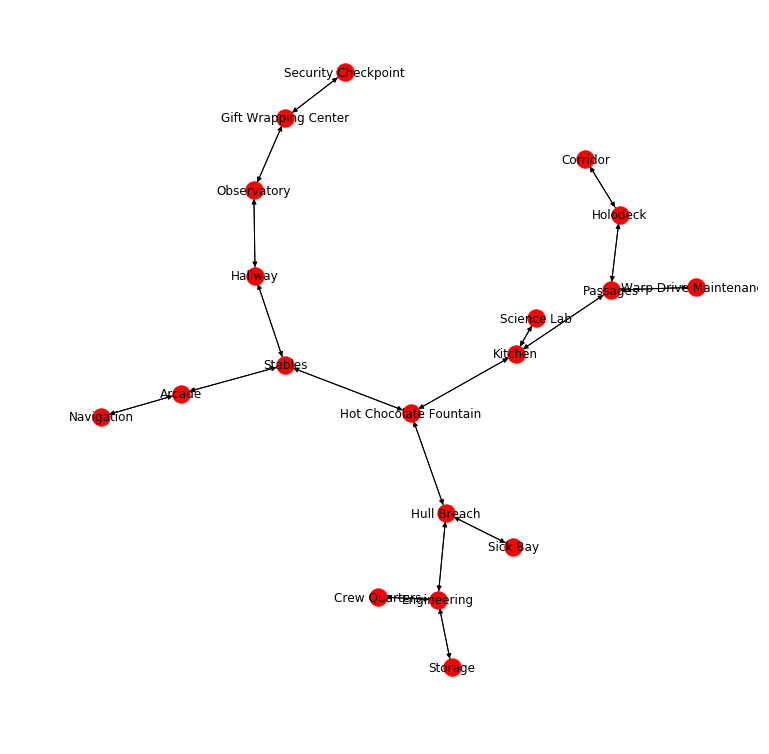

In [79]:
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)

Oh, the Pressure-Sensitive floor boots you back to the Security Checkpoint without you actually taking a step. What we'll do is collect all the items, go to the Security Checkpoint, then see which combination of items allows us to proceed.

In [80]:
# Taking these items exits the game, I learned by trial and error
avoid_items = {
    'molten lava', 'escape pod', 'infinite loop', 'photons', 'giant electromagnet'}

def take_item(prog, item):
    writeline(prog, f'take {item}')

def there_and_back(G, prog, src, dst):
    'Traverse G using prog from src to dst and back, taking items'
    there = nx.shortest_path(G, src, dst)
    back = there[::-1]
    for s, d in its.chain(pairwise(there), pairwise(back)):
        door = G[s][d]['door']
        writeline(prog, door)
        room = parse_room(readlines(prog))
        for item in set(room.items) - avoid_items:
            take_item(prog, item)
            yield item

def goto_room(G, prog, src, dst):
    'Traverse G using prog from src to dst'
    for s, d in pairwise(nx.shortest_path(G, src, dst)):
        writeline(prog, G[s][d]['door'])
        room = readlines(prog)

def collect_items(G, prog, start='Hull Breach'):
    'Traverse G using prog collecting all items'
    taken = { 
        item for dst in G.nodes()
        for item in there_and_back(G, prog, start, dst) }
    return prog, taken

def drop_items(prog, items):
    'Drop the supplied items'
    for item in items:
        writeline(prog, f'drop {item}')
        readlines(prog)

def pass_security_checkpoint(G, prog):
    ''' Return the program once the security checkpoint has been passed
    '''
    # Tactics: collect all items, advance to checkpoint, then drop items
    # until we get to the pressure sensitive floor
    prog, items = collect_items(G, prog)
    goto_room(G, prog, 'Hull Breach', 'Security Checkpoint')
    for stuff in powerset(items):
        progf = prog.fork()
        drop_items(progf, stuff)
        writeline(progf, 'south')
        s = readlines(progf)
        room = parse_room(s)
        if room.name == 'Pressure-Sensitive Floor':
            print(s)
            return progf, set(items) - set(stuff)

prog, items = pass_security_checkpoint(G, Intcode(ints(day(25))))




== Pressure-Sensitive Floor ==
Analyzing...

Doors here lead:
- north

A loud, robotic voice says "Analysis complete! You may proceed." and you enter the cockpit.
Santa notices your small droid, looks puzzled for a moment, realizes what has happened, and radios your ship directly.
"Oh, hello! You should be able to get in by typing 4362 on the keypad at the main airlock."



So, the answer to Day 25, Part 1 is: 4362.